In [ ]:
## Accessing and Using the UN General Debate Corpus (UNGDC):
## A Simple Demonstration using a Jupyter Notebook, Pandas, and SpaCy

# By Nicolas de Zamaroczy

# The purpose of this Python script is to access the UN General Debate Corpus (UNGDC) dataset and then use tools in the SpaCy package to perform simple quantitative text analysis of the corpus.

# The UNGDC dataset was compiled by Slava Jankin Mikhaylov, Alexander Baturo & Niheer Dasandi.
# You can find all of their replication materials on this webpage: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y
# The 2017 article they published in the journal Research & Politics which draws upon the dataset can be found here [pay-walled]: https://journals.sagepub.com/doi/full/10.1177/2053168017712821

# Version 3.3
# Version Changelog:
# - Created an entity column in the df to facilitate subsequent analysis
# - Added visualization of number of countries present at UNGD over time
# - Created an appendix to show how choices in phrase matching affect overall analysis
# - Switched nuclear weapons analysis from Matcher method to PhraseMatcher method, which affected all subsequent analysis and visualizations
# - Clarified matcher.remove function
# - Had similarity analysis section work for the first time
# - Conceptually clarified the Russian discourse over time similarity analysis


In [1]:
## Load necessary packages

# Core Packages
import spacy
from spacy import displacy
from spacy.matcher import Matcher
from spacy.matcher import PhraseMatcher
import en_core_web_lg # Loads the largest version of SpaCy's core English-language library (which has built in words vectors we will use to perform similarity analyses)

# Other Key Packages
import numpy as np # Used to structure data
import pandas as pd # Used to structure data
import seaborn as sns # Used to visualize data
import matplotlib.pyplot as plt # Used to visualize data
%matplotlib inline

# Additional Packages
import os # Used in a few cells to set and walk directories
import re # Used in one cell to write regular expressions
import humanize # Used in one cell to render large numbers in easily interpretable terms
from tqdm import tqdm # Used in several cells to create a progress bar
from tqdm.gui import tqdm as tqdm_gui # Used in several cells to create a progress bar
from pathlib import Path # Used in one cell to write a file to a given directory

In [2]:
## Create a progress bar for long steps

# Some of the below cells can take quite a while to run.
# Accordingly, we use the tqdm package to create a progress bar to help track how long the operation will take
tqdm.pandas(desc='Progress')

C:\Users\nicol\AppData\Roaming\Python\Python37\site-packages\tqdm\std.py:699: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
## Load the files into a dataframe

# Go to https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/0TJX8Y

# Unzip the file named 'UNGDC 1970-2018.zip' to a directory of your choice on your hard drive.
# [This may take a few minutes.]

# In the directory you have chosen, you now have 8,093 speeches in plain text format (with UTF-8 encoding).
# Each speech is named using the following convention: ISO 3166-1 alpha-3 country code, followed by the UN Session number, followed by year.
# E.g. USA_73_2018.txt is the full text of the speech the United States' representative gave during the UN's 73rd General Debate session in 2018.

# To begin, set your working directory to where you saved the zip file
directory = "C:\\Users\\nicol\\Desktop\\Data Science Stuff\\UNGDC\\Text Files"

## If you want to use the test directory, use this line instead
#directory = "C:\\Users\\nicol\\Desktop\\Data Science Stuff\\UNGDC\\Test Folder"

os.chdir(directory) # Changes the directory

# Confirm that working directory is correctly set
print(os.getcwd())

C:\Users\nicol\Desktop\Data Science Stuff\UNGDC\Text Files


In [4]:
# Create a list of all the file names in the working directory
filenames = os.listdir(path=directory)

# Print the first ten file names as a check
print(filenames[:10])

['AFG_26_1971.txt', 'AFG_27_1972.txt', 'AFG_28_1973.txt', 'AFG_29_1974.txt', 'AFG_30_1975.txt', 'AFG_31_1976.txt', 'AFG_32_1977.txt', 'AFG_33_1978.txt', 'AFG_34_1979.txt', 'AFG_35_1980.txt']


In [5]:
# Create the dataframe
# Note: Reading all 8000+ files may take a while

row_list = [] # Create an empty list which we'll eventually cast as a DataFrame

for folder, subfolders, filenames in os.walk(directory): # Use the os.walk module to walk our directory
    for file in filenames: 
        info = {'country_code':file[0:3]}              # Create a series called info which reads the country code from the file name
        info['year'] = file[-8:-4]                        # Add a column called year to info, based on the filename
        with open(directory+'/'+file,encoding='utf-8') as f:   # Open each file in the directory
            info['raw_text'] = f.read()  # Read the contents of the file into a new column of info called text
        row_list.append(info)       # Append all of info to the empty placeholder list
df = pd.DataFrame(row_list)       # Turns our list into a DataFrame named df

# Print the shape of the dataframe as a check
df.shape

(8093, 3)

In [6]:
# Inspect the current dataframe structure
random_subset = df.sample(n=10,replace=False,random_state=101, axis='index') # We choose a random subset of 10 entries in the dataframe to inspect
random_subset

,country_code,year,raw_text
7480,UGA,1992,"Mr. President, allow me to congratulate \nyou ..."
1621,COL,2013,I \nshould like to depart slightly from protoc...
375,AUT,1975,81.\tTogether with all the other Members of th...
3070,GTM,2012,"﻿At the\noutset, allow me to greet Mr. Vuk Jer..."
7551,UKR,2014,"Ukraine, as a co-founder \nof the United Natio..."
7178,TJK,1998,"First allow me to congratulate you, Sir, on yo..."
2228,EGY,1979,"﻿It gives me great pleasure at the outset, Mr...."
4668,MDG,1992,The General \nAssembly's choice of Mr. Ganev t...
7906,YEM,1971,154.\tIt is with great pleasure that I extend ...
3858,KEN,1974,"Mr. President, allow me first to join the prev..."


In [7]:
# Adding Country Names

# Some of the country codes may not be immediately recognizeable to readers.
# Accordingly, we want to add a column with the English-language short version of the country's name.
# We have this information stored in a different CSV file

df_country_names = pd.read_csv('C:\\Users\\nicol\\Desktop\\Data Science Stuff\\UNGDC\\Country Names.csv')
df_country_names.head(10)

,country_code,country_name
0,AFG,Afghanistan
1,AGO,Angola
2,ALB,Albania
3,AND,Andorra
4,ARE,United Arab Emirates
5,ARG,Argentina
6,ARM,Armenia
7,ATG,Antigua and Barbuda
8,AUS,Australia
9,AUT,Austria


In [8]:
# Merge the two dataframes
df = df.merge(df_country_names,how='left')
df = df[['country_code','country_name','year','raw_text']] # Renames the columns
df

,country_code,country_name,year,raw_text
0,AFG,Afghanistan,1971,"82.\tMr. President, at the outset, I wish to c..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat..."
2,AFG,Afghanistan,1973,﻿1.\tIt is a great pleasure for me to congratu...
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ..."
4,AFG,Afghanistan,1975,"114.\t Mr. President, it is a pleasure for the..."
...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate \nMr. Kutesa on assum...
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...


In [9]:
## Text Pre-processing

# As we can see, the raw text strings are full of new paragraph and new line markers.
# As part of our pre-processing, we strip them out.

df['proc_text'] = df['raw_text'].progress_apply(lambda x: x.replace('\n',' '))
df['proc_text'] = df['proc_text'].progress_apply(lambda x: x.replace('\r',' '))
df['proc_text'] = df['proc_text'].progress_apply(lambda x: x.replace('\t',' '))

# There are also both paragraph numbers and page numbers scattered throughout the speeches, leftover as artifacts from the text creation process.
# They have minimal semantic value, so we remove them use a regular expression.
# Note, however, that doing so probably involves some information loss (for instance, if a number ends a sentence), but it's worth the cost.
df['proc_text'] = df['proc_text'].apply(lambda x: re.sub(r'\d+\.','',x)) # Removes any set of digits immediately followed by a period
df

Progress: 100%|████████████████████████████████████████████████████████████████| 8093/8093 [00:00<00:00, 100505.73it/s]


,country_code,country_name,year,raw_text,proc_text
0,AFG,Afghanistan,1971,"82.\tMr. President, at the outset, I wish to c...","Mr. President, at the outset, I wish to congr..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","Mr. President, on behalf of the Afghan delegat..."
2,AFG,Afghanistan,1973,﻿1.\tIt is a great pleasure for me to congratu...,﻿ It is a great pleasure for me to congratulat...
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","Mr. President, permit me to convey to you the ..."
4,AFG,Afghanistan,1975,"114.\t Mr. President, it is a pleasure for the...","Mr. President, it is a pleasure for the dele..."
...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate \nMr. Kutesa on assum...,Allow me to congratulate Mr. Kutesa on assumi...
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,Allow me at the outset to extend to Mr. Mogens...
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","Let me begin my congratulating you, Sir, on yo..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,I wish to congratulate Mr. Miroslav Lajčák on ...


In [10]:
# On the whole, our processed text looks significantly better (and is much better suited for SpaCy, which works best with actual natural speech).

# We can view the text of any given speech (selected by country code and year)
result = df[(df['country_code']=='NAM') & (df['year']=='1990')]['proc_text']    # Change the strings for the year and country code to whatever you want
with pd.option_context('display.max_colwidth', -1):   # If this option is not enabled, the pd.to_string() method truncates the string
    print(result.to_string())

# (We will see additional methods below for grabbing or visualizing the text of a speech once we have created SpaCy doc objects.)

5263    ﻿it gives me great pleasure to address the forty-fifth session of the General Assembly. At the outset, let me extend my heartfelt congratulations to you, Mr. President, on your unanimous election and wish you well in the heavy responsibilities entrusted to you. Your vast experience and diplomatic skill assure us that the work of the Assembly is in good hands. I should like to express my personal happiness and sense of pride to your predecessor, General Joseph Garba, for the efficiency and wisdom with which he steered the forty-fourth session to a successful conclusion. We truly deserves praise by Africa and the world at large for a job well done. The United Nations family was recently reinforced by a new Member, the Principality of Liechtenstein, whose membership my Government warmly welcomes. If I may say so, I had been looking forward to addressing the Assembly as President of the newest Member State of the United Nations. However, the Principality of Liechtenstein overtook u

In [10]:
# Now that we've gotten our processed text, let's drop the raw_text column to save space in our dataframe
df = df.drop(columns=['raw_text'])
df

,country_code,country_name,year,proc_text
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat..."
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ..."
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele..."
...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...


In [11]:
## Creating SpacCy Doc Objects

# The core of the SpaCy package is the doc object, which takes a string of text and calculates the relationship between all the individual words within it at the sentence level.
# (For documentation on doc objects, see https://spacy.io/api/doc)

# Creating a doc object for our speeches is computationally intensive, as each contains thousands of words.
# In addition, we have 8000+ speeches to get through, which can take quite a while to process.
# Accordingly, we take advantage of SpaCy's built-in pipeline feature to process the speeches in batches.

# We begin by instantiating SpaCy's largest English-language library as a pipeline named 'nlp'
nlp = en_core_web_lg.load()
print(nlp.pipe_names)

['tagger', 'parser', 'ner']


In [12]:
# The elements currently in the pipeline are:
# - the tagger, which uses white space and punctuation to figure out what the individual words in the string are and lemmatize them;
# - the dependency-parser, which figures out what part of speech each word is and the relationship between them;
# - the named entity recognizer, which uses syntactic patterns to match tokens against a pre-existing list of known terms.

##We want to disable the parser, which is computationally intensive and which we won't need for the below analysis:
nlp.remove_pipe('parser')
print(nlp.pipe_names)

['tagger', 'ner']


In [13]:
# !! This step can take a very long time (approx. 30 minutes on my machine)!!

df['doc_obj'] = df['proc_text'].progress_apply(lambda x: nlp(x))
# Uses a lambda expression to create a SpaCy Doc Object from each pre-processed string, which are stored in a new column called doc_obj
df

Progress: 100%|████████████████████████████████████████████████████████████████████| 8093/8093 [31:43<00:00,  4.25it/s]


,country_code,country_name,year,proc_text,doc_obj
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha..."
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c..."
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to..."
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f..."
...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ..."
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M..."
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj..."


In [14]:
# Verify that the 'doc_obj' column does indeed contain SpaCy doc objects
type(df['doc_obj'][0])

spacy.tokens.doc.Doc

In [15]:
## Visualizing Named Entity Recognition (NER) in Individual Doc_Objs

displacy_options = {'ents': ['PERSON','NORP','FAC','ORG','GPE','LOC','EVENT','LAW','LANGUAGE']}
# The above activates some of Spacy's built-in entity categories, but not all of them.
# For all the options, see: https://spacy.io/usage/visualizers#ent)

displacy.render(df['doc_obj'][0], style='ent', options = displacy_options,jupyter=True)

In [16]:
# A different example

displacy.render(df[(df['country_code']=='CUB') & (df['year']=='1979')]['doc_obj'],
                style='ent', options = displacy_options,jupyter=True)

In [18]:
# You can access the recognized entities in a doc object by calling:
df['doc_obj'][60].ents

(﻿First,
 the General Assembly,
 forty-fifth,
 today,
 the Government of the People's Republic of Angola,
 Joseph Garba,
 forty-fourth,
 sixteenth,
 Africa,
 eighteenth,
 the past few years,
 States,
 Namibia,
 African,
 Germany,
 Africa,
 Nelson Mandela,
 South Africa,
 Africa,
 South Africa,
 Angola,
 Mozambique,
 Angolan,
 one year ago,
 Gbadolite,
 the National Union,
 UNITA,
 the United States,
 South African,
 the Government of Angola,
 Angolans,
 Gbadolite,
 UNITA,
 Gbadolite,
 UNITA,
 UNITA,
 the Angolan Government's,
 Lave,
 four,
 Portugal,
 fourth,
 UNITA,
 The Angolan Government,
 Angola,
 UNITA,
 the Political Parties Law,
 State,
 UMITA,
 second,
 the Angolan Government,
 fourth,
 UNITA,
 Angola,
 the United States,
 Angola,
 United States,
 New York,
 Africa,
 Security Council,
 435,
 1978,
 Namibian,
 Cuban,
 Africa,
 Angola,
 Cuba,
 Angola,
 more than 38,000,
 the People's Republic of Angola,
 about four years,
 about 5 million,
 2 million,
 the United Nations,
 Angola

In [19]:
# To allow for subsequent analysis, let's create a new column in our df for relevant entities in each speech
df['ents'] = df['doc_obj'].progress_apply(lambda x: x.ents)
df

## The above currently works, but what I'd really like is to do something like the below
#ent_types = ['PERSON','NORP','FAC','ORG','GPE','LOC','EVENT','LAW','LANGUAGE']
#df['ents'] = df['doc_obj'].progress_apply(lambda x: x.ents if ent.label_ in ent_types)
#df

Progress: 100%|███████████████████████████████████████████████████████████████████| 8093/8093 [00:24<00:00, 326.46it/s]


,country_code,country_name,year,proc_text,doc_obj,ents
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...","((the, General, Assembly), (Afghanistan), (Ind..."
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...","((President), (Afghan), (seventh), (the, Gener..."
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...","((Afghanistan), (twenty, -, eighth), (the, Gen..."
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...","((President), (the, Republic, of, Afghanistan)..."
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...","((the, Republic, of, Afghanistan), (thirtieth)..."
...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...","((Kutesa), (the, General, , Assembly), (sixty..."
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...","((Mogens, Lykketoft), (the, General, Assembly)..."
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...","((the, General, Assembly), (Mogens, Lykketoft)..."
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...","((Miroslav, Lajčák), (the, General, Assembly),..."


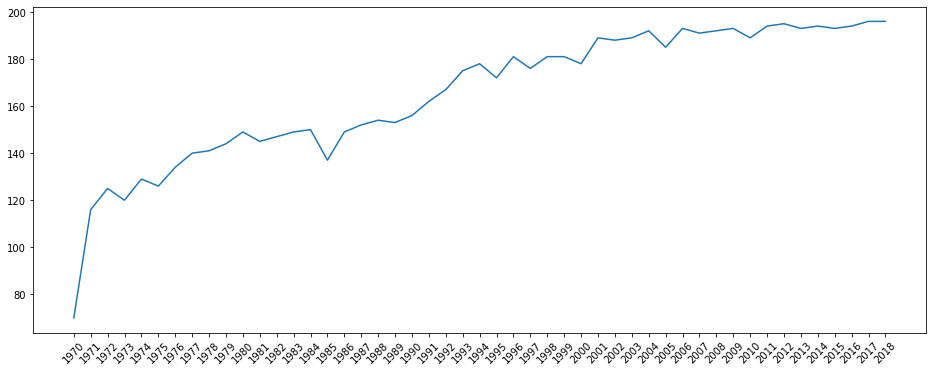

In [20]:
# The number of countries present at the UNGD has increased over time (due to new countries joining the UN)

number_speeches = df.groupby(['year'])['country_name'].apply(lambda x: len(x))

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.ylabel=('Number of Countries') # Line not working for some reason
plt.xlabel=('Year') # Line not working for some reason
plt.plot(number_speeches)

In [35]:
## Nuclear weapons analysis

# The imminent entry into force of the Treaty on the Prohibition of Nuclear Weapons on January 22, 2021
# (following its ratification by 50 countries) seems like a good impetus to see how nuclear weapons are discussed in UN General Debates.

# We can use SpaCy's Matcher method to check each document for specific phrases.
# Note: Choices you make with regard to phrase matching affect your substantive results. See Appendix 1 for a demonstration.
# SpaCy has both a Matcher method, matches based on patterns (for instance, regular expressions), as well as a PhraseMatcher method but SpaCy also has a PhraseMatcher method, which works well for multi-token phrases.
# After testing, we are going to use the PhraseMatcher method.

matcher = PhraseMatcher(nlp.vocab, attr="LOWER") # 'Lower' ensures that all our searching is case-insensitive
nuke_terms = ['nuclear weapon', 'nuclear weapons', 'nuclear armament', 'nuclear armaments', 'nuclear arsenal',
            'atomic weapon', 'atomic weapons', 'atomic armament', 'atomic armaments', 'atomic arsenal',
            'strategic weapon', 'strategic weapons', 'strategic armament', 'strategic armaments', 'strategic arsenal']
patterns = [nlp.make_doc(text) for text in nuke_terms]
matcher.add('nuke_terms', None, *patterns)

df['nuke_mentions'] = df['doc_obj'].progress_apply(lambda x: len(matcher(x)))
df

Progress: 100%|███████████████████████████████████████████████████████████████████| 8093/8093 [00:11<00:00, 734.60it/s]


,country_code,country_name,year,proc_text,doc_obj,ents,nuke_mentions
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...","((the, General, Assembly), (Afghanistan), (Ind...",0
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...","((President), (Afghan), (seventh), (the, Gener...",0
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...","((Afghanistan), (twenty, -, eighth), (the, Gen...",0
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...","((President), (the, Republic, of, Afghanistan)...",1
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...","((the, Republic, of, Afghanistan), (thirtieth)...",4
...,...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...","((Kutesa), (the, General, , Assembly), (sixty...",0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...","((Mogens, Lykketoft), (the, General, Assembly)...",0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...","((the, General, Assembly), (Mogens, Lykketoft)...",0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...","((Miroslav, Lajčák), (the, General, Assembly),...",0


[Text(0, 0.5, 'Total Mentions of Nuclear Weapons'), Text(0.5, 0, 'Year')]

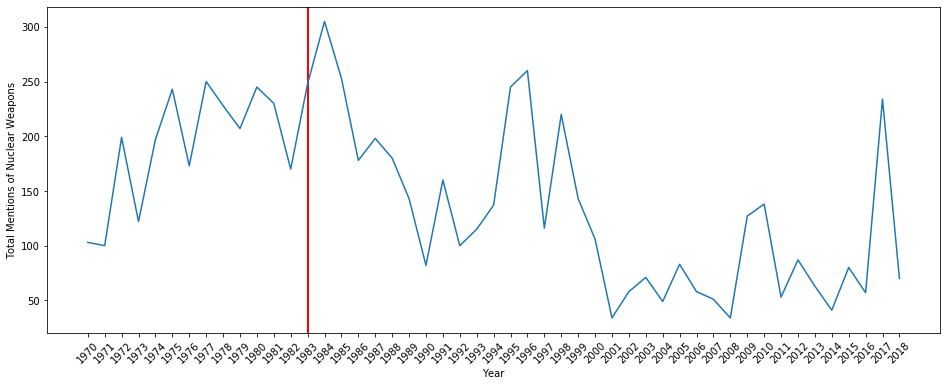

In [24]:
# Visualizing Mentions of Nuclear Weapons in the UNGD over Time

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(13,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig1 = sns.lineplot(data=df, x='year', y='nuke_mentions', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig1.set(xlabel='Year', ylabel='Total Mentions of Nuclear Weapons') # Why does this line randomly print a bunch of output text?

In [25]:
# The above chart is suggestive.
# The greatest number of mentions is during the early 1980s, a period which many historians view as a 'New Cold War' following the detente of the 1970s (see: https://en.wikipedia.org/wiki/Cold_War#New_Cold_War_(1979%E2%80%931985)).
# Indeed, 1983 (marked by a red line above) was arguably the year the planet came closest to full-blown nuclear war: see (**shameless plug warning**): https://nicolasdezamaroczy.com/2018/09/22/did-we-almost-all-die-in-november-1983/
# Another peak is during the mid-1990s, when there were acute worries about the status of nuclear weapons in the former Soviet bloc following the dissolution of the USSR.
# By comparison, the post-Cold War world saw a significant drop in attention paid to nuclear weapons.

# Before moving on with our analysis, it's worth noting a few things about how our matching has been done.
# First, we aren't attempting to deal with negation at all.
# Our method treats "Nuclear weapons are a major problem" the same as "Nuclear weapons aren't a problem".
# Second, we aren't attempting to measure the meanings attributed to nuclear weapons.
# For instance, our method doesn't differentiate between "Nuclear weapons are an important source of stability in the world" and "Nuclear weapons constitute the gravest danger to world peace."
# In principle, we could do an analysis that does take meaning into account by leveraging a combination of collocation analysis and sentiment analysis, both of which are built-into SpaCy.
# While collocation could be done using the span method in SpaCy, SpaCy does not have sentiment analysis built in, so we're going to pass on that for the time being.

# In what year were nuclear weapons most discussed?
df.groupby(['year'])['nuke_mentions'].sum().idxmax()

'1984'

In [26]:
# What was the least number of mentions of nuclear weapons in a single year?
df.groupby(['year'])['nuke_mentions'].sum().min()

34

In [27]:
# Which countries mention nuclear weapons the most?  Which countries mention them the least?
df.groupby(['country_name'])['nuke_mentions'].sum().sort_values(ascending=False)

country_name
Russia            256
China             188
Ukraine           166
Japan             156
New Zealand       155
                 ... 
European Union      1
South Sudan         0
Serbia              0
Moldova             0
Eritrea             0
Name: nuke_mentions, Length: 200, dtype: int64

In [28]:
# But if you look at it closely, the previous list is partially an artifact of the number of appearances at the UNGD.
# For instance, Ukraine and New Zealand have attended all the sessions of the UNGD since 1970 (indeed, both were founding members of the UN.)
# However, South Sudan and the EU (in its own capacity) both only began participating at the UNGD in 2011.

# So what we're really interested is the average number of nuke mentions per year attended:
avg_nuke_mentions = df.groupby(['country_name'])['nuke_mentions'].mean().sort_values(ascending=False)
avg_nuke_mentions.rename('avg_nuke_mentions',inplace=True)

country_name
Russia          5.333333
East Germany    4.500000
China           3.916667
Ukraine         3.387755
North Korea     3.250000
                  ...   
Comoros         0.023810
South Sudan     0.000000
Serbia          0.000000
Moldova         0.000000
Eritrea         0.000000
Name: avg_nuke_mentions, Length: 200, dtype: float64

[Text(0, 0.5, 'Country'),
 Text(0.5, 0, 'Average Yearly Mentions of Nuclear Weapons')]

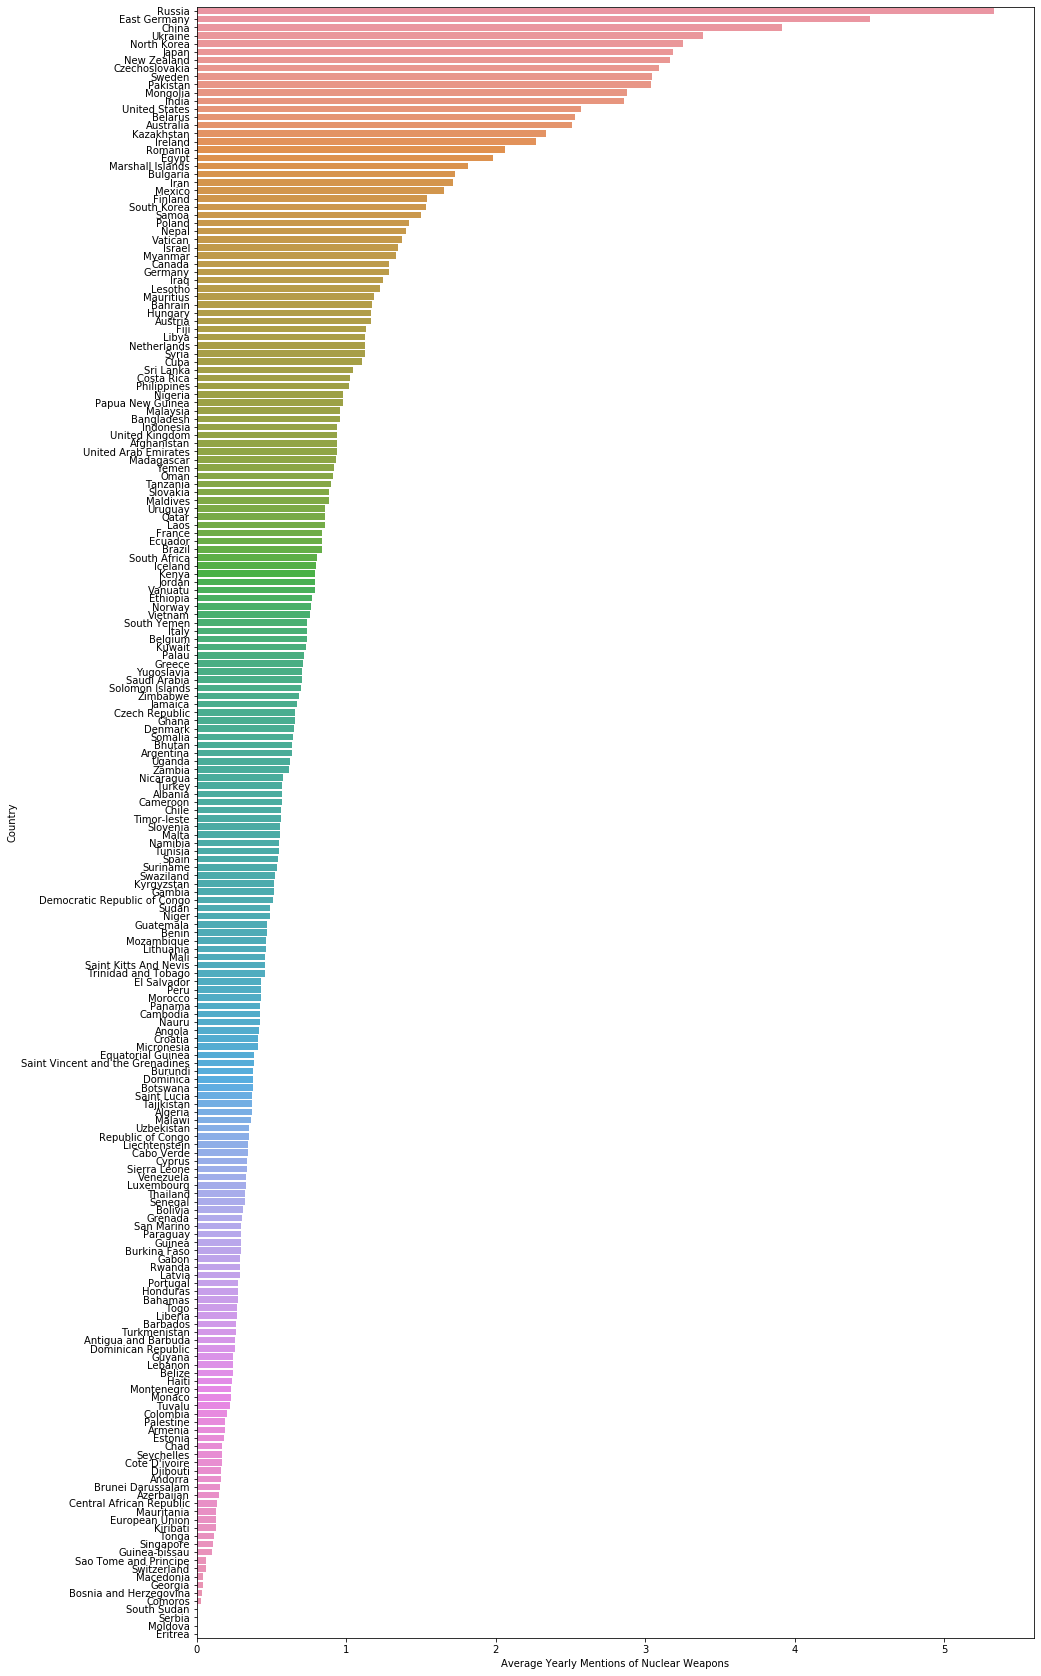

In [32]:
# Visualizing Mentions of Nuclear Weapons by Country

# Graphically, the above series looks something like this
plt.figure(figsize=(15, 30))
fig2 = sns.barplot(y=avg_nuke_mentions.index,x=avg_nuke_mentions.values, orient = 'h')
fig2.set(xlabel='Average Yearly Mentions of Nuclear Weapons', ylabel='Country') # I'm not sure why this line randomly prints a bunch of output text

In [36]:
## Climate change analysis

# We're now going to repeat the above analysis, but switching the focus from nuclear weapons to climate change.
# Because the terms we're most interested in--"climate change" and "global warming" are actually multi-token phrases rather than single words,
# we're going to switch from using SpaCy's Mathcher method to its PhraseMatcher method.

len(matcher) # Shows that the matcher object still has the nuke terms from above
matcher.remove('nuke_terms')

climate_terms = ['climate change', 'global warming','carbon emissions']
patterns = [nlp.make_doc(text) for text in climate_terms]
matcher.add('climate_terms', None, *patterns)
len(matcher)==1 # Should result in True

True

In [37]:
df['climate_mentions'] = df['doc_obj'].progress_apply(lambda x: len(matcher(x)))
df

Progress: 100%|█████████████████████████████████████████████████████████████████| 8093/8093 [00:00<00:00, 12077.97it/s]


,country_code,country_name,year,proc_text,doc_obj,ents,nuke_mentions,climate_mentions
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...","((the, General, Assembly), (Afghanistan), (Ind...",0,0
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...","((President), (Afghan), (seventh), (the, Gener...",0,0
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...","((Afghanistan), (twenty, -, eighth), (the, Gen...",0,0
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...","((President), (the, Republic, of, Afghanistan)...",1,0
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...","((the, Republic, of, Afghanistan), (thirtieth)...",4,0
...,...,...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...","((Kutesa), (the, General, , Assembly), (sixty...",0,0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...","((Mogens, Lykketoft), (the, General, Assembly)...",0,0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...","((the, General, Assembly), (Mogens, Lykketoft)...",0,0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...","((Miroslav, Lajčák), (the, General, Assembly),...",0,5


[Text(0, 0.5, 'Total Mentions of Climate Change'), Text(0.5, 0, 'Year')]

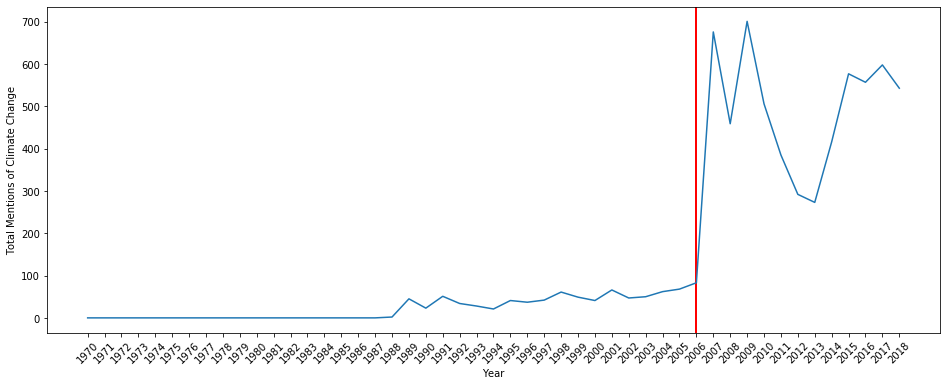

In [38]:
# Visualizing Mentions of Climate Change in the UNGD over Time

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(36,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig3 = sns.lineplot(data=df, x='year', y='climate_mentions', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig3.set(xlabel='Year', ylabel='Total Mentions of Climate Change') # Not sure why this line randomly prints some text at the beginning

In [40]:
# I'm not saying that it's the only factor, but 2006 was the year Al Gore's "An Inconvenient Truth" was released.
# Gore and the Inter-Governmental Panel on Climate Change (IPCC) jointly won the Nobel Peace Prize in 2007.

# In what year, and by which countries, was climate change first brought up in a UN General Debate session?

grouped_df = df[df['climate_mentions'] != 0].drop(columns=['proc_text','doc_obj','nuke_mentions','country_code','ents'])
grouped_df.groupby(['year'])
grouped_df.sort_values(by=['year']).head(30)

## I feel like the code in this cell could be cleaner

,country_name,year,climate_mentions
1258,Canada,1988,2
901,Belize,1989,2
3797,Japan,1989,2
999,Brazil,1989,1
1728,Costa Rica,1989,1
3554,Iceland,1989,1
7624,United States,1989,1
5548,Nepal,1989,3
1847,Cyprus,1989,1
291,Antigua and Barbuda,1989,2


In [41]:
# In what year did the greatest number of countries mention climate change?
grouped_df.groupby(['year'])['country_name'].nunique().sort_values(ascending=False).head()

year
2009    169
2007    160
2017    157
2016    153
2010    149
Name: country_name, dtype: int64

In [42]:
# On average, which countries most mention climate change?  On average, which countries least mention climate change?
# (Same analysis as above in the nuke section)

avg_climate_mentions = df.groupby(['country_name'])['climate_mentions'].mean().sort_values(ascending=False)
avg_climate_mentions.rename('avg_climate_mentions',inplace=True)

country_name
Tuvalu            11.555556
Kiribati           9.500000
Micronesia         7.555556
Palau              5.809524
Samoa              5.558824
                    ...    
Israel             0.020408
South Yemen        0.000000
Czechoslovakia     0.000000
East Germany       0.000000
Yugoslavia         0.000000
Name: avg_climate_mentions, Length: 200, dtype: float64

[Text(0, 0.5, 'Country'),
 Text(0.5, 0, 'Average Yearly Mentions of Climate Change')]

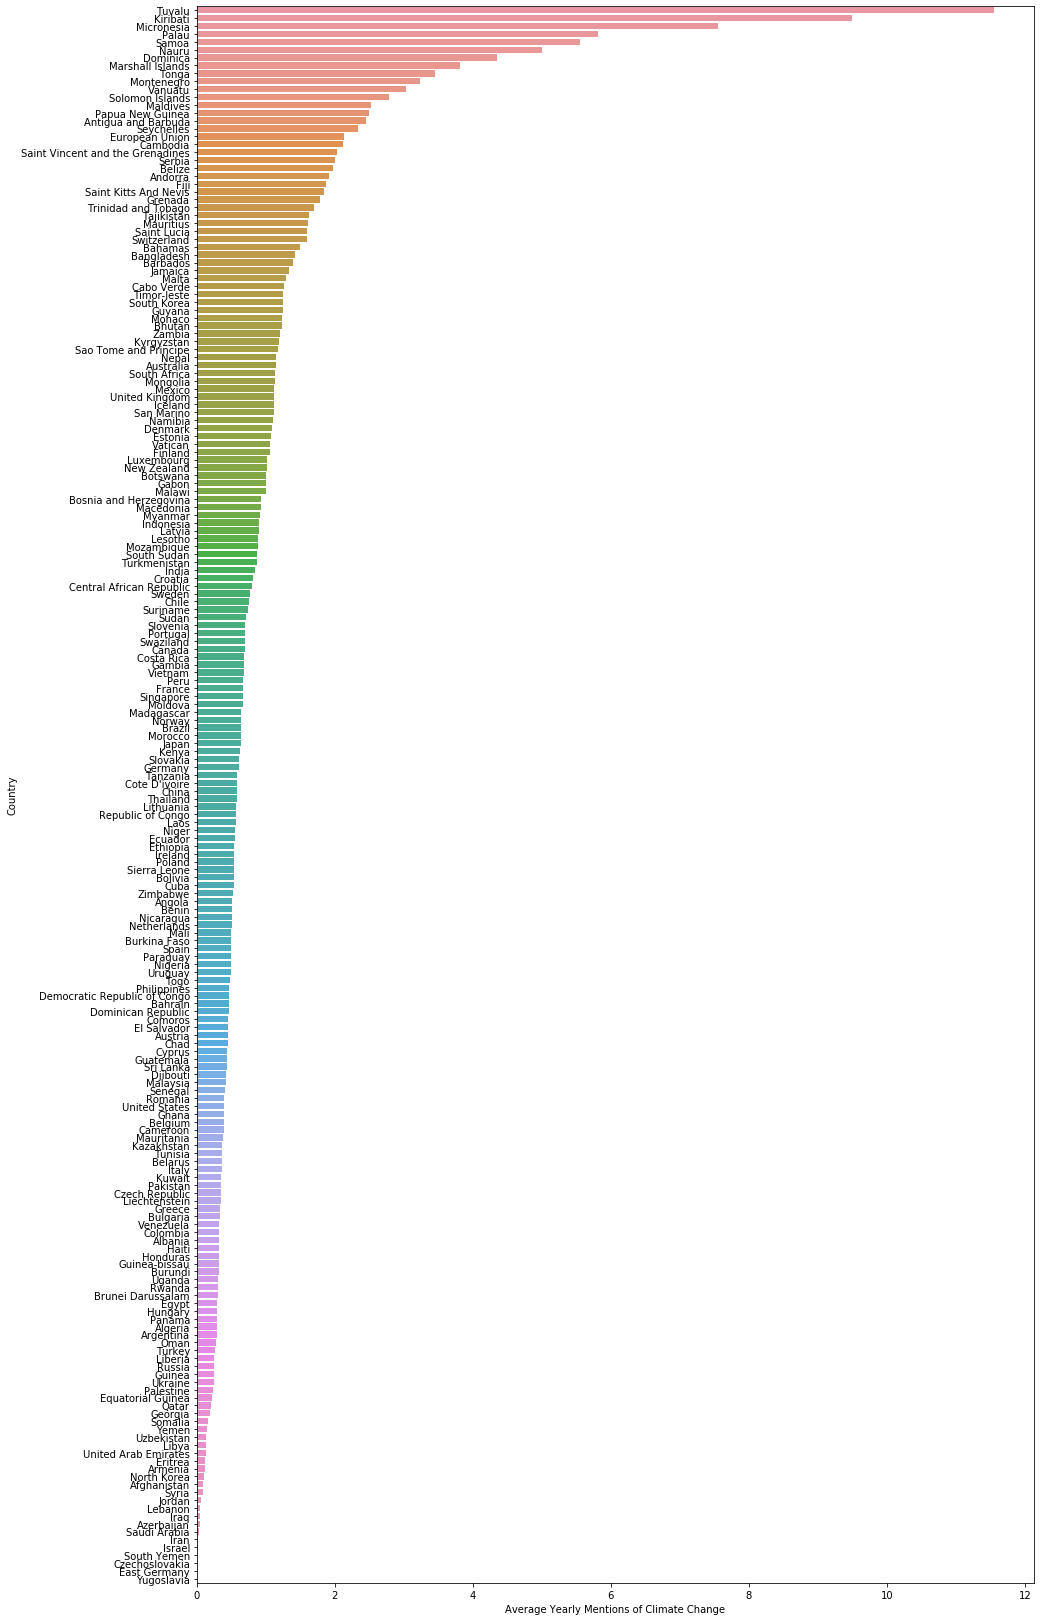

In [43]:
# Unsurprisingly, small island nations which face existential threats from rising sea levels mention climate change a lot. 
# Equally unsurprisingly, countries which ceased to exist prior to the mid-2000s never mentioned climate change.

# Visualizing Mentions of Climate Change by Country

plt.figure(figsize=(15, 30))
fig4 = sns.barplot(y=avg_climate_mentions.index,x=avg_climate_mentions.values, orient = 'h')
fig4.set(xlabel='Average Yearly Mentions of Climate Change', ylabel='Country')

In [46]:
## Similarity Analysis

# SpaCy can automatically calculate the similarity of two documents based on the words they contain.
# (For a brief explanation of the math underlying word vectorization, see: https://towardsdatascience.com/understanding-nlp-word-embeddings-text-vectorization-1a23744f7223)

# Let's look at some examples.
# In 2016 (the year of the Brexit referendum), was the UK's speech more similar to the EU's speech or to the US' speech?

target_doc = nlp(str(df[(df['country_code']=='GBR') & (df['year']=='2016')]['proc_text']))
 
comparison_doc1 = nlp(str(df[(df['country_code']=='EU_') & (df['year']=='2016')]['proc_text']))
comparison_doc2 = nlp(str(df[(df['country_code']=='USA') & (df['year']=='2016')]['proc_text']))

print(target_doc.similarity(comparison_doc1))
print(target_doc.similarity(comparison_doc2))

0.9236728261662517
0.9274824956522746


In [47]:
# Similarity scores always range from 0 (no lingustic similarity) to 1 (exactly the same word vectors used).

# The first thing to note about the scores above is the high degree of linguistic similarity across all the documents,
# which isn't that suprising once you realize that they are all similarly structured speeches addressed to a same audience on roughly similar topics.

# Still, at least for that year, it seems that the UK's speech was a tad more similar to the US than the EU's, which might indicate that Brexit was imminent.

In [45]:
## Appendix 1: Phrase Matching Considerations in NLP

# Decisions about how exactly you do phrase matching can significantly affect your findings.

# Below I present two different ways of doing the matching analysis to get the count of nuclear weapons mentions.

# A good sample text to make sure the pattern is picking up true positives and skipping false negatives is KOR_49_1994


## Option 1: Broader, But More Likely to Grab False Positives
# We use SpaCy's Matcher method to check each document for specific terms and phrases.

matcher1 = Matcher(nlp.vocab)
matcher1.add('nuke_mentions', None,
            [{'LOWER': 'nuclear'}],
            [{'LOWER': 'atomic'}])
df['nuke_mentions_matcher1'] = df['doc_obj'].progress_apply(lambda x: len(matcher1(x)))

## Pros of the method: will capture basically anything related to nuclear or atomic weapons.
## Cons: Yields false positives, like matching on 'nuclear energy', which it should not.
# One possible solution would be to write a regular expression that matches on 'nuclear' unless it's followed by ' energy'
# For something along those lines, see: https://velenux.wordpress.com/2011/07/23/ignore-a-word-in-a-regular-expression/


## Option 2: Narrow Targeting, But Likely to Miss True Positives
# We use SpaCy's Phrase Matcher method to match multi-token phrases

matcher2 = PhraseMatcher(nlp.vocab, attr="LOWER")
nuke_terms = ['nuclear weapon', 'nuclear weapons', 'nuclear armament', 'nuclear armaments', 'nuclear arsenal',
            'atomic weapon', 'atomic weapons', 'atomic armament', 'atomic armaments', 'atomic arsenal',
            'strategic weapon', 'strategic weapons', 'strategic armament', 'strategic armaments', 'strategic arsenal']
patterns = [nlp.make_doc(text) for text in nuke_terms]
matcher2.add('nuke_terms', None, *patterns)
df['nuke_mentions_matcher2'] = df['doc_obj'].progress_apply(lambda x: len(matcher2(x)))

## Pros: Very narrowly targeted, ensures no false positives
## Cons: May miss things substantively related to nuclear weapons, as in this sentence: 'Weapons of mass destruction, especially nuclear ones, threaten our collective survival.'

df

Progress: 100%|██████████████████████████████████████████████████████████████████| 8093/8093 [00:04<00:00, 1661.75it/s]


,country_code,country_name,year,proc_text,doc_obj,ents,nuke_mentions_matcher1,nuke_mentions_matcher2
0,AFG,Afghanistan,1971,"Mr. President, at the outset, I wish to congr...","( , Mr., President, ,, at, the, outset, ,, I, ...","((the, General, Assembly), (Afghanistan), (Ind...",0,0
1,AFG,Afghanistan,1972,"Mr. President, on behalf of the Afghan delegat...","(Mr., President, ,, on, behalf, of, the, Afgha...","((President), (Afghan), (seventh), (the, Gener...",0,0
2,AFG,Afghanistan,1973,﻿ It is a great pleasure for me to congratulat...,"(﻿, It, is, a, great, pleasure, for, me, to, c...","((Afghanistan), (twenty, -, eighth), (the, Gen...",3,0
3,AFG,Afghanistan,1974,"Mr. President, permit me to convey to you the ...","(Mr., President, ,, permit, me, to, convey, to...","((President), (the, Republic, of, Afghanistan)...",8,1
4,AFG,Afghanistan,1975,"Mr. President, it is a pleasure for the dele...","( , Mr., President, ,, it, is, a, pleasure, f...","((the, Republic, of, Afghanistan), (thirtieth)...",9,4
...,...,...,...,...,...,...,...,...
8088,ZWE,Zimbabwe,2014,Allow me to congratulate Mr. Kutesa on assumi...,"(Allow, me, to, congratulate, , Mr., Kutesa, ...","((Kutesa), (the, General, , Assembly), (sixty...",0,0
8089,ZWE,Zimbabwe,2015,Allow me at the outset to extend to Mr. Mogens...,"(Allow, me, at, the, outset, to, extend, to, M...","((Mogens, Lykketoft), (the, General, Assembly)...",0,0
8090,ZWE,Zimbabwe,2016,"Let me begin my congratulating you, Sir, on yo...","(Let, me, begin, my, congratulating, you, ,, S...","((the, General, Assembly), (Mogens, Lykketoft)...",0,0
8091,ZWE,Zimbabwe,2017,I wish to congratulate Mr. Miroslav Lajčák on ...,"(I, wish, to, congratulate, Mr., Miroslav, Laj...","((Miroslav, Lajčák), (the, General, Assembly),...",0,0


[Text(0, 0.5, 'Total Yearly Mentions of Nuclear Weapons'),
 Text(0.5, 0, 'Year')]

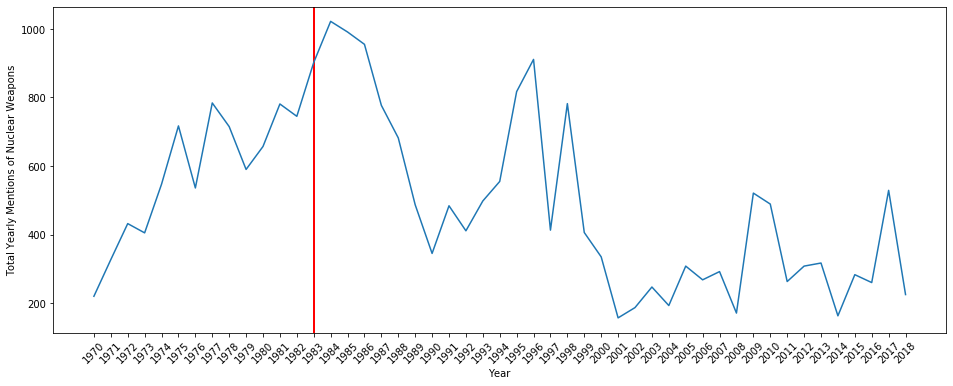

In [46]:
# Visualization of Option 1

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(13,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig1 = sns.lineplot(data=df, x='year', y='nuke_mentions_matcher1', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig1.set(xlabel='Year', ylabel='Total Yearly Mentions of Nuclear Weapons')

[Text(0, 0.5, 'Total Yearly Mentions of Nuclear Weapons'),
 Text(0.5, 0, 'Year')]

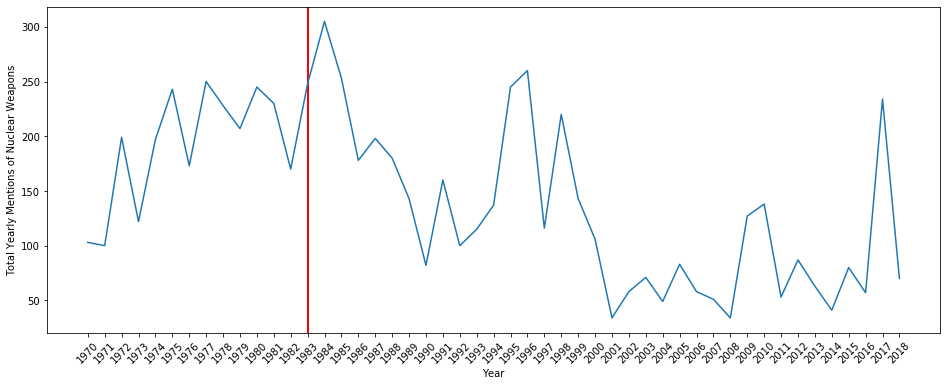

In [47]:
# Visualization of Option 2

plt.figure(figsize=(16, 6))
plt.xticks(rotation=45)
plt.axvline(13,0,1, linewidth=2, color='r') # Plots a vertical red line which runs from 0% to 100% of the y-axis at the 13th data point on the x-axis
fig1 = sns.lineplot(data=df, x='year', y='nuke_mentions_matcher2', ci=None, estimator=np.sum,) # If you don't specify the estimator as a summing function, it reports back the mean number of mentions per country
fig1.set(xlabel='Year', ylabel='Total Yearly Mentions of Nuclear Weapons')